### Karşılaştırma



=== Model: cnn_functional ===
              precision    recall  f1-score   support

         cat       0.94      0.86      0.90       960
         dog       0.93      0.97      0.95      1996

    accuracy                           0.94      2956
   macro avg       0.94      0.92      0.92      2956
weighted avg       0.94      0.94      0.93      2956



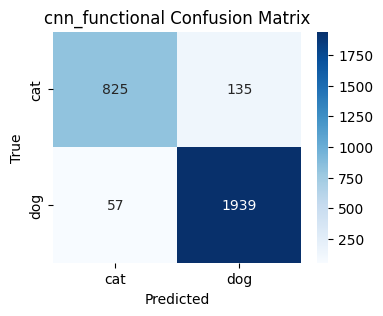


=== Model: resnet_feature ===


              precision    recall  f1-score   support

         cat       0.82      0.69      0.75       960
         dog       0.86      0.93      0.89      1996

    accuracy                           0.85      2956
   macro avg       0.84      0.81      0.82      2956
weighted avg       0.85      0.85      0.85      2956



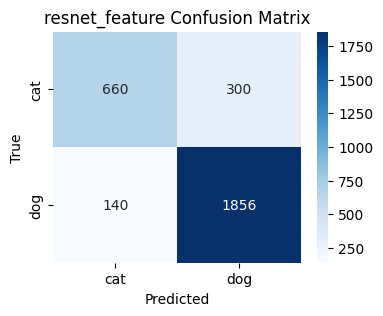


=== Model: resnet_finetune ===


              precision    recall  f1-score   support

         cat       0.94      0.96      0.95       960
         dog       0.98      0.97      0.97      1996

    accuracy                           0.97      2956
   macro avg       0.96      0.96      0.96      2956
weighted avg       0.97      0.97      0.97      2956



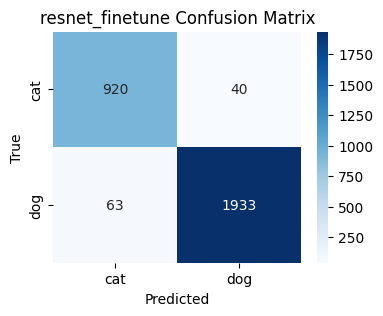

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# 1. Sabitler
IMG_SIZE_SMALL = (128, 128)
IMG_SIZE_LARGE = (224, 224)
DATA_ROOT = Path(r"C:\Users\hdgn5\OneDrive\Masaüstü\Bilgisayar Proglamlama\images")

MODEL_PATHS = {
    "cnn_functional":      "binary_cnn_functional_256_128_64_32.h5",
    "resnet_feature":      "best_resnet50_feature.h5",
    "resnet_finetune":     "best_resnet50_finetune.h5",
}

def collect_paths(root):
    exts = (".jpg", ".jpeg", ".png")
    return sorted(p for p in Path(root).rglob("*") if p.suffix.lower() in exts)

def build_df(paths):
    df = pd.DataFrame({
        "path":  [str(p) for p in paths],
        "label": [p.stem.split("_")[0] for p in paths]
    })
    cat_set = {"Abyssinian","Birman","Bengal","Bombay","British",
               "Egyptian","Maine","Persian","american","english"}
    df["binary"] = df["label"].apply(lambda x: 0 if x in cat_set else 1)
    return df

def df_to_numpy(df, size):
    X, y = [], []
    for p, lbl in zip(df["path"], df["binary"]):
        img = tf.io.read_file(p)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size) / 255.0
        X.append(img.numpy())
        y.append(int(lbl))
    return np.stack(X), np.array(y)

all_paths = collect_paths(DATA_ROOT)
df_all    = build_df(all_paths)
_, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all["binary"], random_state=42)
X_small, y_test = df_to_numpy(df_test, IMG_SIZE_SMALL)

# 3. Modelleri yükle ve raporla
for name, model_file in MODEL_PATHS.items():
    print(f"\n=== Model: {name} ===")
    model = load_model(model_file)

    if name.startswith("resnet_"):
        X = tf.image.resize(X_small, IMG_SIZE_LARGE).numpy() * 255.0
        X = resnet_preprocess(X)
    else:
        X = X_small

    y_prob = model.predict(X, batch_size=32, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    print(classification_report(y_test, y_pred, target_names=["cat", "dog"]))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["cat","dog"], yticklabels=["cat","dog"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()